# Programma per importare dati da QUADERA #

_Autore: Carlo Roncolato_

_Data: 03/12/2024_

## Definizioni ##

In [11]:
import os
import re
import tkinter as tk
from tkinter import filedialog
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm



formato_data = "%d/%m/%Y %H:%M:%S"  # Specifica il formato della stringa


In [2]:
def leggi_intestazione(file_path):
    # Dizionario per memorizzare i dati estratti
    intestazione = {}
    
    # Apri il file in modalità lettura
    with open(file_path, 'r') as file:
        # Leggi il contenuto del file riga per riga
        for line in file:
            # Rimuovi spazi bianchi iniziali e finali dalla riga
            line = line.strip()

            # Cerca e memorizza i dati con le espressioni regolari
            if line.startswith("Sourcefile"):
                intestazione["Sourcefile"] = line.split("\t")[1]  # Estrae il nome del file
                data_str = intestazione["Sourcefile"].split(" ")[1]
                data_pm = datetime.strptime(data_str, "%H%M%S").hour > 12
            elif line.startswith("Exporttime"):
                intestazione["Exporttime"] = datetime.strptime(line.split("\t")[1], formato_data) # Estrae il tempo di esportazione
            elif line.startswith("Start Time"):
                intestazione["Start Time"] = datetime.strptime(line.split("\t")[1], formato_data) # Estrae l'orario di inizio
            elif line.startswith("End Time"):
                intestazione["End Time"] = datetime.strptime(line.split("\t")[1], formato_data)  # Estrae l'orario di fine
                break

        if data_pm:
            intestazione["Start Time"] = intestazione["Start Time"] + timedelta(hours=12)
    return intestazione

In [3]:
def seleziona_file():
    # Crea una finestra principale nascosta per il file dialog
    root = tk.Tk()
    root.withdraw()  # Nasconde la finestra principale
    # Apri il file explorer per selezionare un file
    file_path = filedialog.askopenfilename(
        title="Seleziona il file",
        filetypes=[("Text files", "*.asc"), ("All files", "*.*")]
    )
    return file_path

In [4]:
#estratti = [
#    (
#        (
#            blocco["Start Time"] - intestazione["Start Time"]).total_seconds(),
#            [blocco["Mass/IonCurrent"][i][1] for i in indici]
#        ) 
#    for blocco in blocchi]

def read_bargraph_cycles(file_path):
    blocchi = []  # Lista per contenere i blocchi letti dal file
    indici = (2, 18, 28, 32, 44)
    
    with open(file_path, 'r') as file:
        blocco = {}
        for line in file:
            line = line.strip()
            
            if line.startswith("Task Name"):
                if blocco:  # Se c'è già un blocco, lo aggiungiamo alla lista
                    blocchi.append(blocco)
                blocco = {"Mass/IonCurrent": []}  # Iniziamo un nuovo blocco
                blocco["Task Name"] = line.split("\t")[1]
                
            elif line.startswith("First Mass"):
                blocco["First Mass"] = float(line.split("\t")[1].replace(',', '.'))
                
            elif line.startswith("Scan Width"):
                blocco["Scan Width"] = float(line.split("\t")[1].replace(',', '.'))
                
            elif line.startswith("Start Time"):
                blocco["Start Time"] = datetime.strptime(line.split("\t")[1], formato_data)
                
            elif line.startswith("Mass [amu]"):
                # Iniziamo a leggere le coppie di valori (Mass, Ion Current)
                continue  # La riga di intestazione non contiene dati
                
            else:
                # Rileva le righe di dati "Mass [amu] <numero> Ion Current [A] <numero>"
                match = re.match(r"(\d+,\d+)\t([+-]?\d+\,\d+e[+-]?\d+)", line)
                if match:
                    mass = float(match.group(1).replace(',', '.'))  # Converte il mass in float
                    ion_current = float(match.group(2).replace(',', '.'))  # Ion Current è già un numero float
                    if mass in indici:
                        blocco["Mass/IonCurrent"].append((mass, ion_current))
        
        # Aggiungiamo l'ultimo blocco e togliamo il primo
        if blocco:
            blocchi.append(blocco)
            blocchi.pop(0)

    # Rimuoviamo i blocchi incompleti
    if blocchi:
        blocchi = [blocco for blocco in blocchi if len(blocco["Mass/IonCurrent"]) == blocco["Scan Width"] ]
    
    return blocchi

In [5]:
def read_mainElements_cycles(file_path):
   
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Time/IonCurrent": []}  # Iniziamo un nuovo blocco

        for line in tqdm(file):
            line = line.rstrip()
            
            if line.startswith("\t\t"):
                blocco["Mass Indexes"] = [int(x) for x in line.strip().split("\t\t\t") if re.match(r"0?[1-9]", x)]

            elif line.startswith("Time"):
                # Iniziamo a leggere le coppie di valori (Mass, Ion Current)
                continue  # La riga di intestazione non contiene dati
             
            else:
                # Rileva le righe di dati
                pattern = r"(0[1-9]|1[0-2])/(0?[1-9]|[12][0-9]|3[01])/\d{4}"
                match = re.match(pattern, line)
                if match:
                    lettura = line.replace(',', '.')
                    serie_letture = [elemento.strip() for elemento in lettura.split("\t")]
                
                    if len(serie_letture) >= (len(blocco["Mass Indexes"]) - 1) * 3 + 2:
                        tempo_lettura = (float(serie_letture[1]) + float(serie_letture[-2]))/2
                        lista_correnti = []
                    
                        for idx, dato in enumerate(blocco["Mass Indexes"]):
                            corrente = serie_letture[idx*3 + 2]
                            lista_correnti.append(float(corrente))

                        blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])

    return blocco

In [16]:
def read_analog_cycles(file_path):
   
    i = 0         # inizializza l'indice del blocco
    
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Time/IonCurrent": [], "Mass Indexes": []}  # Iniziamo un nuovo blocco
        
        task_name_encountered = 0
        
        tempo_inizio = 0
        tempo_lettura = 0
        
        lista_masse = []
        lista_correnti = []
        
        for line in tqdm(file, desc="Lettura del file"):
            line = line.strip()
            
            if line.startswith("Task Name"):
                task_name_encountered += 1
                if task_name_encountered == 1:
                    # print("Skipping first task name")
                    continue  # La prima volta continua il ciclo
                else:
                    # Se c'è già un blocco, lo aggiungiamo alla lista
                    # print("Adding block", i)                  
                    blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])
                    blocco["Mass Indexes"].append([tempo_lettura, lista_masse])

                # incrementa indice del blocco e reset delle variabili
                i += 1 
                lista_correnti = []
                lista_masse = []
                # print("blocco", i)
                
            elif line.startswith("Start Time"):
                if tempo_inizio == 0:
                    tempo_inizio = datetime.strptime(line.split("\t")[1], formato_data)
                
                lettura = datetime.strptime(line.split("\t")[1], formato_data)
                tempo_lettura = (lettura - tempo_inizio).total_seconds()
                # print(i, lettura, tempo_inizio, tempo_lettura)
                
            else:
                # Rileva le righe di dati "Mass [amu] <numero> Ion Current [A] <numero>"
                match = re.match(r"(\d+.\d+)\t([+-]?\d+\.\d+e[+-]?\d+)", line.replace(',', '.'))
                if match:
                    massa = float(match.group(1).replace(',', '.'))
                    corrente_ionica = float(match.group(2).replace(',', '.'))  # Ion Current è già un numero float
                    lista_masse.append(massa)
                    lista_correnti.append(corrente_ionica)
                    
    # Aggiungiamo l'ultimo blocco
    if blocco: 
        # print("Adding block", i)                  
        blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])
        blocco["Mass Indexes"].append([tempo_lettura, lista_masse])    

    # Pulizia dei blocchi incompleti  
    lunghezza_blocco = [len(row[1]) for row in blocco["Mass Indexes"]]  
    posizioni_incomplete = [i for i, value in enumerate(lunghezza_blocco) if value != max(lunghezza_blocco)]
    blocco["Time/IonCurrent"] = [row for i, row in enumerate(blocco["Time/IonCurrent"]) if i not in posizioni_incomplete]
    blocco["Mass Indexes"] = [row for i, row in enumerate(blocco["Mass Indexes"]) if i not in posizioni_incomplete]
    blocco["Mass Indexes"] = blocco["Mass Indexes"][0][1]

    return blocco

## Importazione Dati ##

### Selezione del file di input ###

In [7]:
# Esegui il programma con la selezione del file tramite il selettore
# file_path = seleziona_file()
file_path = "./data/20250110 161151 Scan_analog_mod.asc"

In [17]:

if os.path.exists(file_path):
    intestazione = leggi_intestazione(file_path)
    if "Scan_main_elements" in intestazione["Sourcefile"]:
        dati = read_mainElements_cycles(file_path)
        print("Tipo File: Scan_Main_Elements")
    elif "Bargraph Cycles" in intestazione["Sourcefile"]:
        dati = read_bargraph_cycles(file_path)
        print("Tipo File: Bargraph Cycles")
    elif "Scan_analog_mod" in intestazione["Sourcefile"]:
        dati = read_analog_cycles(file_path)
        print("Tipo File: Analog Cycles")
    else:
        print("Formato non risconosciuto")
        
    if intestazione:
        # Stampa i dati estratti
        print("Nome del file: ",intestazione["Sourcefile"])
        print("Numero di Blocchi Dati: ",len(dati["Time/IonCurrent"]))
        print("Start Time:", intestazione["Start Time"])
        print("End Time:", intestazione["End Time"])
        
        durata = intestazione["End Time"] - intestazione["Start Time"]
        print("Durata", durata.total_seconds())
        print(dati["Mass Indexes"])

else:
    print("Nessun file selezionato.")

Lettura del file: 7856925it [00:17, 460740.43it/s]


Tipo File: Analog Cycles
Nome del file:  20250110 161151 Scan_analog_mod.qmp
Numero di Blocchi Dati:  4886
Start Time: 2025-01-11 04:11:57
End Time: 2025-01-13 14:38:21
Durata 210384.0
[0.0, 0.03, 0.06, 0.09, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.38, 0.41, 0.44, 0.47, 0.5, 0.53, 0.56, 0.59, 0.63, 0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.88, 0.91, 0.94, 0.97, 1.0, 1.03, 1.06, 1.09, 1.13, 1.16, 1.19, 1.22, 1.25, 1.28, 1.31, 1.34, 1.38, 1.41, 1.44, 1.47, 1.5, 1.53, 1.56, 1.59, 1.63, 1.66, 1.69, 1.72, 1.75, 1.78, 1.81, 1.84, 1.88, 1.91, 1.94, 1.97, 2.0, 2.03, 2.06, 2.09, 2.13, 2.16, 2.19, 2.22, 2.25, 2.28, 2.31, 2.34, 2.38, 2.41, 2.44, 2.47, 2.5, 2.53, 2.56, 2.59, 2.63, 2.66, 2.69, 2.72, 2.75, 2.78, 2.81, 2.84, 2.88, 2.91, 2.94, 2.97, 3.0, 3.03, 3.06, 3.09, 3.13, 3.16, 3.19, 3.22, 3.25, 3.28, 3.31, 3.34, 3.38, 3.41, 3.44, 3.47, 3.5, 3.53, 3.56, 3.59, 3.63, 3.66, 3.69, 3.72, 3.75, 3.78, 3.81, 3.84, 3.88, 3.91, 3.94, 3.97, 4.0, 4.03, 4.06, 4.09, 4.13, 4.16, 4.19, 4.22, 4.25, 4

### Secondo file di input da unire ###

Aggiunge la serie di dati selezionata a quella appena importata. Poi riferisce tutti i tempi in funzione della prima serie.

In [10]:
# Esegui il programma con la selezione del file tramite il selettore
file_path_bis = seleziona_file()

TclError: no display name and no $DISPLAY environment variable

In [62]:
if file_path_bis:
    intestazione_bis = leggi_intestazione(file_path_bis)
    if "Scan_main_elements" in intestazione["Sourcefile"]:
        dati_bis = read_mainElements_cycles(file_path_bis)
        print("Tipo File: Scan_Main_Elements")
    elif "Bargraph Cycles" in intestazione_bis["Sourcefile"]:
        dati_bis = read_bargraph_cycles(file_path_bis)
        print("Tipo File: Bargraph Cycles")
    elif "Scan_analog_mod" in intestazione["Sourcefile"]:
        dati = read_analog_cycles(file_path)
        print("Tipo File: Analog Cycles")
    else:
        print("Formato non risconosciuto")

   # Stampa i dati estratti
    print("Nome del file: ",intestazione_bis["Sourcefile"])
    print("Numero di Blocchi Dati: ",len(dati_bis["Time/IonCurrent"]))
    print("Start Time:", intestazione_bis["Start Time"])
    print("End Time:", intestazione_bis["End Time"])
    durata_bis = intestazione_bis["End Time"] - intestazione_bis["Start Time"]
    print("Durata", durata_bis.seconds)

else:
    print("Nessun file selezionato.")

Tipo File: Scan_Main_Elements
Nome del file:  20241211 114858 Scan_main_elements.qmp
Numero di Blocchi Dati:  0
Start Time: 2024-12-11 11:50:36.976000
End Time: 2024-12-11 03:35:41.431000
Durata 56704


In [50]:
delta = (intestazione_bis["Start Time"] - intestazione["Start Time"]).total_seconds()
for punto in dati_bis["Time/IonCurrent"]:
    punto[0] = punto[0] + delta
dati["Time/IonCurrent"] = dati["Time/IonCurrent"] + dati_bis["Time/IonCurrent"]

## Visualizzazione ##

In [9]:
colori = ("b", "g", "r", "c", "k", "y", "m")
mostra_masse = [2, 18, 28, 32, 40, 44]

indici = {num: [i for i, x in enumerate(dati["Mass Indexes"]) if x == num] for num in mostra_masse}
print(indici)

{2: [64], 18: [576], 28: [896], 32: [1024], 40: [1280], 44: [1408]}


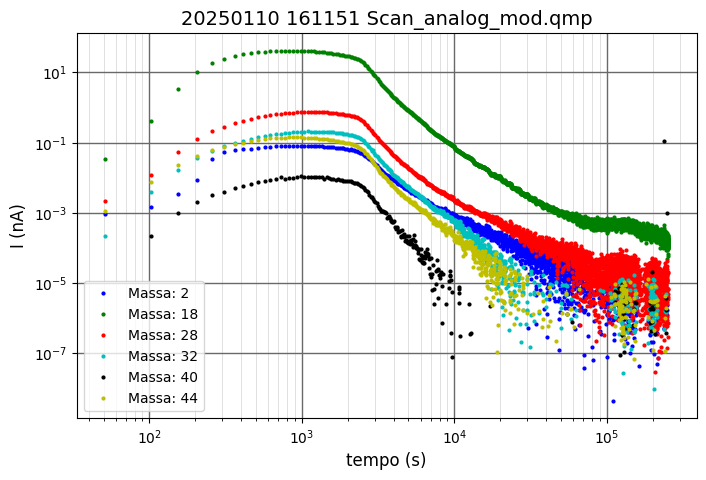

In [21]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
for idx, massa in enumerate(indici):
    pos = indici[massa][0]
    x = [punto[0] for punto in dati["Time/IonCurrent"]]
    y = [punto[1][pos]*1e9 for punto in dati["Time/IonCurrent"]]

    # plt.loglog o plot.semilogy
    plt.loglog(
                x, y,
                marker="o", 
                markersize=2,
                linestyle='',
                color=colori[idx],
                label='Massa: '+ f"{massa}"
    )
    
# Personalizzazione del grafico
plt.title(intestazione["Sourcefile"], fontsize=14)
plt.xlabel('tempo (s)', fontsize=12)
plt.ylabel('I (nA)', fontsize=12)
#plt.grid(True, which="both", linestyle='-', alpha=0.6)
plt.grid(which="major", color="dimgray", linewidth=1.0)
plt.grid(which="minor", color="lightgray", linewidth=0.5)
plt.legend(fontsize=10)

# Mostra il grafico
plt.show()

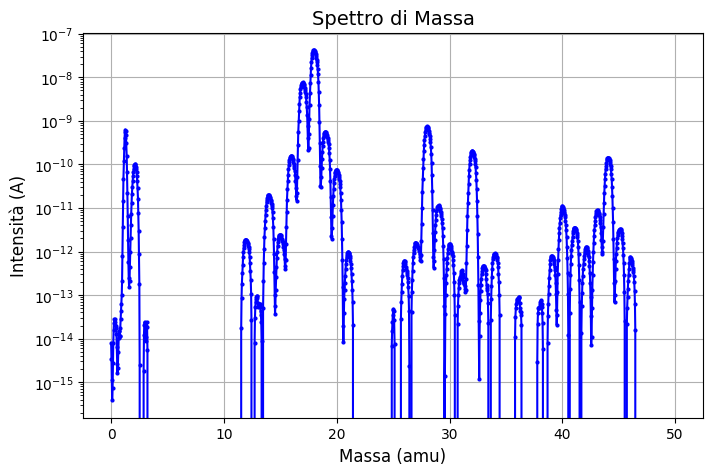

In [18]:
t = [punto[0] for punto in dati["Time/IonCurrent"]]
target = 1000  # esempio di valore target
posizione_piu_vicina = min(range(len(t)), key=lambda i: abs(t[i] - target))
spettro_y = dati["Time/IonCurrent"][posizione_piu_vicina][1]
spettro_x = dati["Mass Indexes"]
plt.figure(figsize=(8, 5))
plt.semilogy(spettro_x, spettro_y, marker="o", markersize=2, linestyle='-', color='b')
plt.title('Spettro di Massa', fontsize=14)
plt.xlabel('Massa (amu)', fontsize=12)
plt.ylabel('Intensità (A)', fontsize=12)
plt.grid(True)
plt.show()